In [13]:
import pymysql.cursors
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio.Phylo.Applications import FastTreeCommandline
from Bio import Phylo
%matplotlib inline
import scipy.cluster.hierarchy as cl
import scipy.spatial.distance as ssd
import matplotlib
import matplotlib.pyplot as plt


In [19]:
class sea_inphinity():
    def __init__(self, db_name):
        self.db_name = db_name
        self.connection()
        
    def connection(self):
        # Connect to the database
        self.connection = pymysql.connect(host='localhost',
                                     user='root',
                                     password='',
                                     db=self.db_name,
                                     charset='utf8mb4',
                                     cursorclass=pymysql.cursors.DictCursor)
        
    def simple_execute(self, sql, verbose):
        try:
            with self.connection.cursor() as cursor:
                res = cursor.execute(sql)

                if verbose:
                    print(res)

            self.connection.commit()
        finally:
            pass
        
    def get_pham(self):
        cur = self.connection.cursor()

        cur.execute("SELECT * FROM pham")

        for row in cur:
            print(row)

        return cur
    
    def get_specific_pham(self, name, verbose):
        cur = self.connection.cursor()

        cur.execute("SELECT GeneID FROM pham WHERE name = %s", (name))

        if verbose:
            for row in cur:
                print(row)

        return cur
    
    def get_list_genes(self, gene_ids, verbose):
        cur = self.connection.cursor()
        
        sql = "SELECT * FROM gene WHERE GeneID IN ('%s');" % ( "','".join(gene_ids))
        
        cur.execute(sql)

        if verbose:
            for row in cur:
                print(row)

        return list(cur.fetchall())
    
    def build_tree(self,pham):
        genes = self. get_genes_from_a_pham(pham)
        self.create_fasta(genes)
        self.align_muscle()
        self.compute_tree()
        self.draw_tree()
    
    def get_genes_from_a_pham(self, pham):
        pham_list = []
        
        pham = sea_inphinity.get_specific_pham(pham, False)
        for id in pham:
            pham_list.append(id['GeneID'])
        #print(pham_2784_list)
        genes = sea_inphinity.get_list_genes(pham_2784_list, False)
        
        return genes
        
    def create_fasta(self, genes):
        print('Creation of the FASTA file')
        fasta = open("fasta.fa", "w")
        for gene in genes:
            GeneID = gene['GeneID']
            name = gene['Name']
            description = ">%s - %s" % (GeneID, name)

            translation = gene['translation']

            print(description)
            print(translation)

            fasta.write(description)
            fasta.write('\n')
            fasta.write(translation)
            fasta.write('\n')

        fasta.close()
        
    def align_muscle(self):
        print('Alignment with MUSCLE')
        muscle_loc = r'/home/pa/work/muscle3.8.31_i86linux64' # modifier si nécessaire

        muscle_cline = MuscleCommandline(cmd=muscle_loc,input='fasta.fa',out='out.aln',clwstrict=True)
        stdout, stderr = muscle_cline()

        muscle_align = AlignIO.read('out.aln','clustal')
        print(muscle_align)
        
    def compute_tree(self):
        print('Compute tree')
        AlignIO.convert('out.aln','clustal','intermediate.phy', 'phylip-relaxed')

        cmd_fasttree = r'fasttree'
        fasttree_cmdline = FastTreeCommandline(cmd=cmd_fasttree,fastest=True, \
                                               input='intermediate.phy',out='tree.tre')
        out_log, err_log = fasttree_cmdline()

        print('Out Log:')
        print(out_log)

        print('Error Log')
        print(err_log)
        
        tree = Phylo.read('tree.tre', 'newick')
        
    def draw_tree(self):
        print('Draw tree')
        dmat = []
        leaves = [str(cladit) for k,cladit in enumerate(tree.get_terminals())]
        for l1,leave1 in enumerate(leaves):
            d = []
            for l2,leave2 in enumerate(leaves):
                d.append(tree.distance(leave1,leave2))
            dmat.append(d)
            
        Z = cl.linkage(ssd.squareform(dmat),method='average',metric='euclidean')
        fig = plt.figure(num=None,figsize=(30,25),dpi=250)
        dendro=cl.dendrogram(Z,labels=leaves,color_threshold=0.06,leaf_rotation=90,leaf_font_size=10)
        plt.show()

Creation of the FASTA file
>148603_20 - 20
MSKILTLDTIREEADREYGAPVQVQISKDTTVSLKNVMRLRKDVRKDILTQLEAIRTINDKAGGDKTEADAEKLADAVFKILELAAGRASETLMDAVDEDVALATKILNYWLEETQVGEASSSED
>148603_21 - 21
MSKILTLDTIREEADREYGAPVQVQISKDTTVSLKNVMRLRKDVRKDILTQLEAIRTINDKAGGDKTEADAEKLADAVFKILELAAGRASETLMDAVDEDVALATKILNYWLEETQVGGSLQLGGLIDDYGDALYADFRAEYHMNLADLFDPASRLGPIQVLALIKELPREGRFWSEKQGGPQFRGWDDQTYTTAALVNEIRALKFMYLLANTSKDKRRRLTPPEPFPVPRVKPHKAKKYKPGSFGAVAAMRMAASRNRKARTTGG
>205870_24 - 24
MSNVFTLDSFREEADREFAPVKLELGGDDAVVLRNVLRIQKTRREEVFQLLEKLDSIAKDDEGKQREEDDLDASEMEAMGDIALRMIELVADNDALGSRLVDELRDDLALTLKVFEAWMNATQPGEAERSPA
>205870_25 - 25
MDERDPAGGSRALARLIDEYGDCLVADLWETYGVDLRDIYLPESRLSPKLALVLIKELPVGSRFYAEKRGGKQFRGWDESRYALVAIVNAVRALQYTYVAAHSKSKPKPPDPFPTPQRTKARQIRKAGSFAWMAAKQIAAARKRKAQT
>260120_gp21 - gp21
MSKILTLDTIREEADREYGAPVQVQISKDTTVSLKNVMRLRKDARKDILTQLEAIRTINDKADGDKTEADAEKLADAVFKILELTAGRDSETLMDAVDEDVALATKILNYWLEETQAGEASSSED
>260120_gp22 - gp22
MNLADLFDPASRLGPIQVLALIKELPREGRFWSEKQGGPQFRGWTDQTYTTAALVNEIRALKFMYLLA

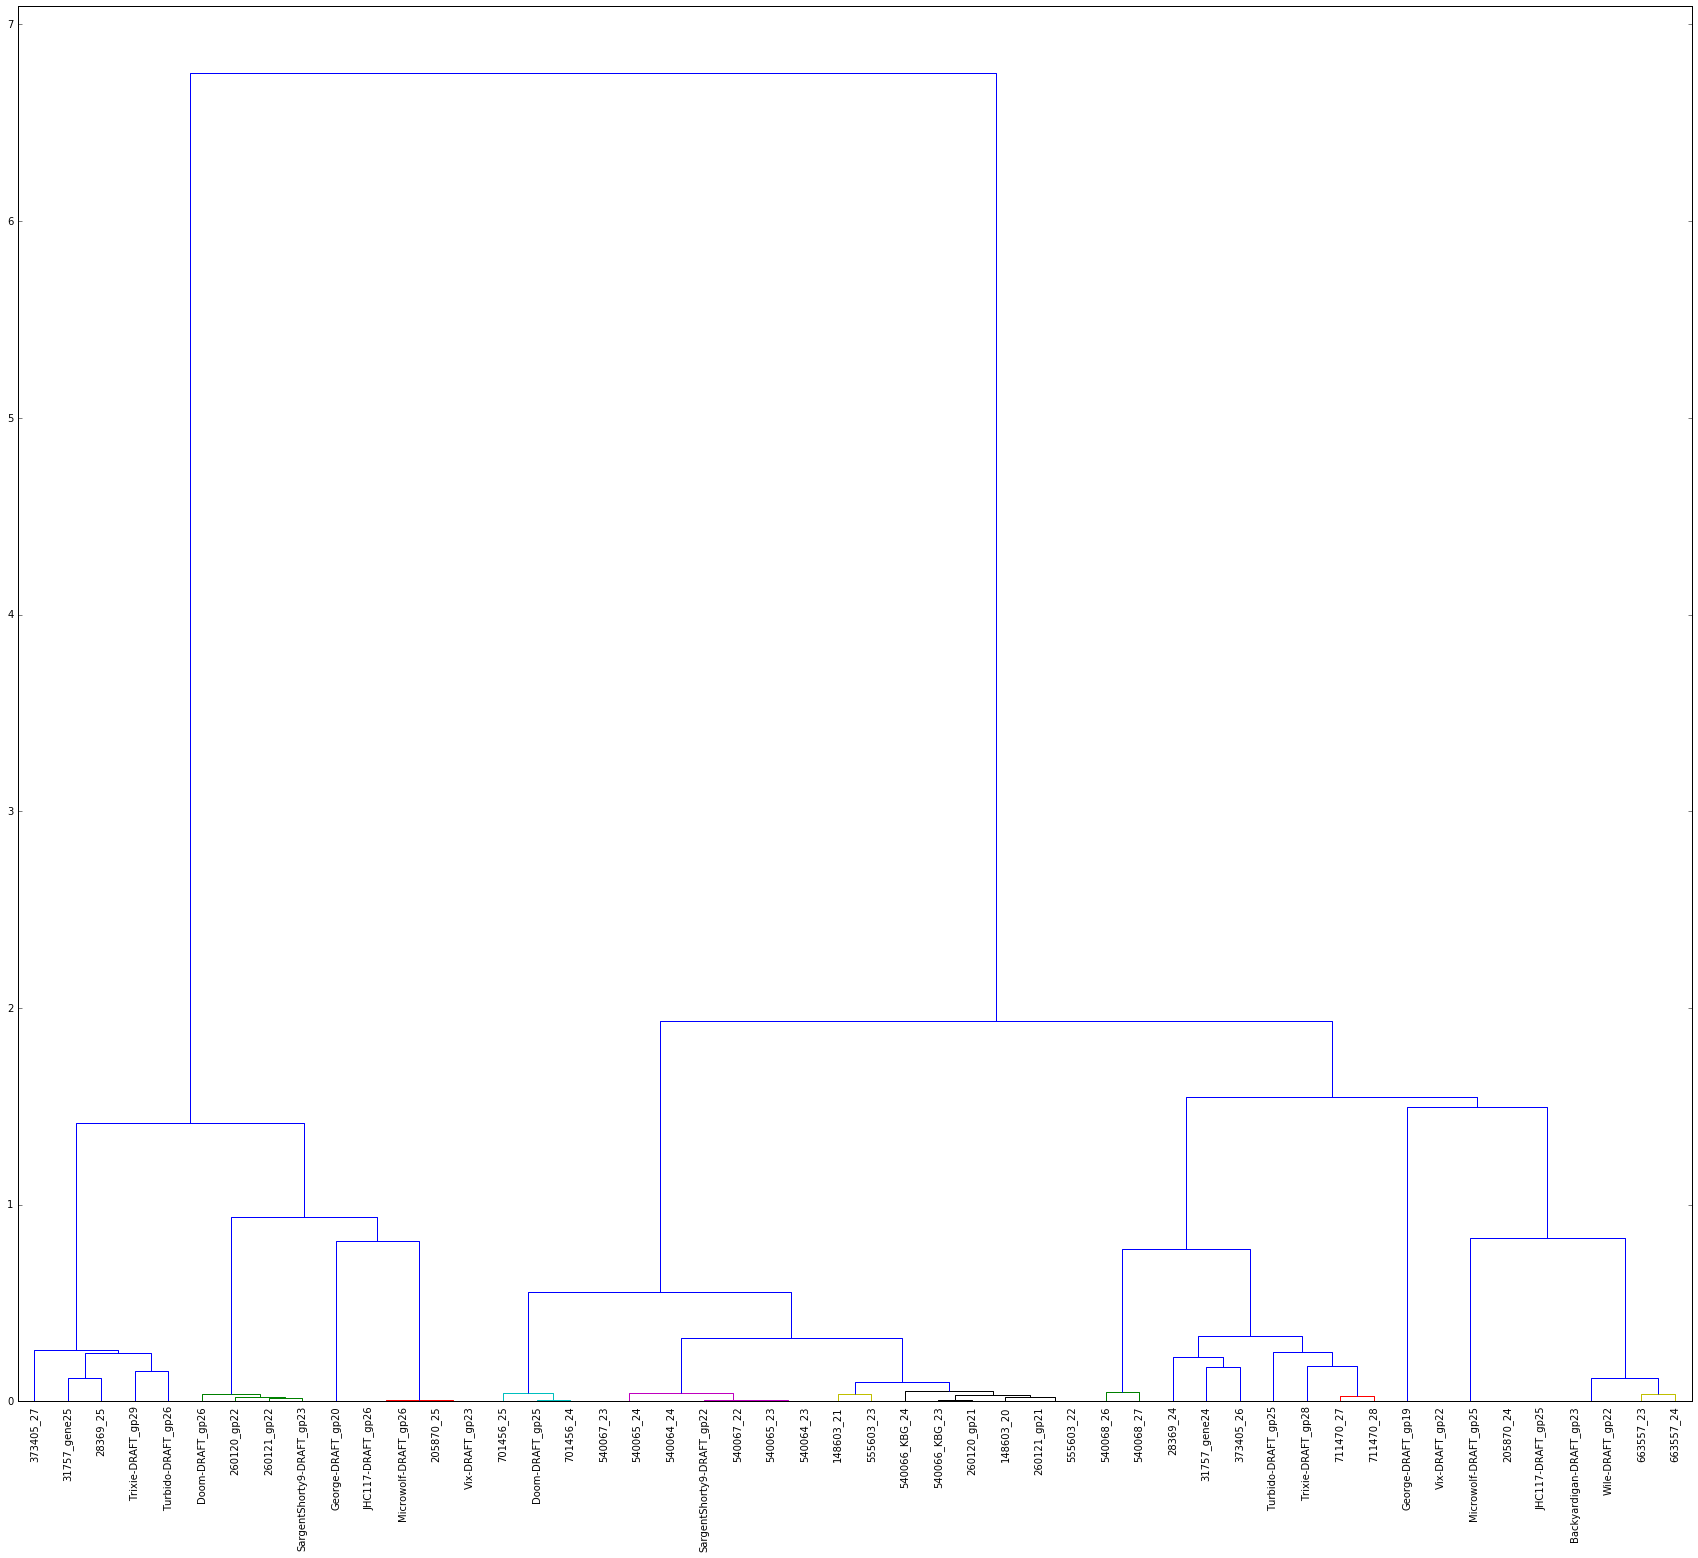

In [20]:
sea_inphinity = sea_inphinity('sea')
sea_inphinity.build_tree('2784')